# Task 3: A/B Hypothesis Testing

## Hypotheses to test:
1. There are no risk differences across provinces
2. There are no risk differences between zipcodes
3. There is no significant margin (profit) difference between zip codes
4. There is no significant risk difference between Women and men

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the data (use df_valid from previous analysis or reload)
# Let's reload to be sure we have clean data
df = pd.read_csv('../data/raw/insurance_data.txt', delimiter='|', low_memory=False)

# Convert key columns
df['TotalPremium'] = pd.to_numeric(df['TotalPremium'], errors='coerce')
df['TotalClaims'] = pd.to_numeric(df['TotalClaims'], errors='coerce')
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')

# Filter out zero premiums for accurate analysis
df_valid = df[df['TotalPremium'] > 0].copy()
df_valid['LossRatio'] = df_valid['TotalClaims'] / df_valid['TotalPremium']

print(f"Data loaded. Shape: {df_valid.shape}")
print(f"Valid policies (premium > 0): {len(df_valid):,}")

Data loaded. Shape: (618176, 53)
Valid policies (premium > 0): 618,176


In [3]:
# Cell 3: Hypothesis Test 1 - Risk differences across provinces
print("=" * 60)
print("HYPOTHESIS TEST 1: Risk differences across provinces")
print("=" * 60)
print("Null Hypothesis: There are no risk differences across provinces")
print("Alternative Hypothesis: There ARE risk differences across provinces")
print()

# Check provinces in data
print("Provinces in dataset:")
print(df_valid['Province'].value_counts())
print()

# We'll use ANOVA test to compare means across provinces
# First, check assumptions
print("Checking ANOVA assumptions...")

# 1. Normality - Shapiro-Wilk test on sample from each province
print("1. Normality check (Shapiro-Wilk on samples):")
for province in df_valid['Province'].unique():
    sample = df_valid[df_valid['Province'] == province]['LossRatio'].dropna().sample(min(5000, len(df_valid[df_valid['Province'] == province])), random_state=42)
    stat, p = stats.shapiro(sample)
    print(f"   {province:20} p-value: {p:.4f} {'(Normal)' if p > 0.05 else '(Not Normal)'}")
print()

# 2. Homogeneity of variances - Levene's test
print("2. Homogeneity of variances (Levene's test):")
levene_stat, levene_p = stats.levene(*[df_valid[df_valid['Province'] == province]['LossRatio'].dropna() 
                                       for province in df_valid['Province'].unique()])
print(f"   Levene's test p-value: {levene_p:.4f}")
print(f"   {'Variances are equal' if levene_p > 0.05 else 'Variances are NOT equal'}")
print()

# 3. Perform ANOVA (even if assumptions violated - we'll interpret cautiously)
print("3. One-way ANOVA results:")
anova_result = stats.f_oneway(*[df_valid[df_valid['Province'] == province]['LossRatio'].dropna() 
                                for province in df_valid['Province'].unique()])
print(f"   F-statistic: {anova_result.statistic:.4f}")
print(f"   p-value: {anova_result.pvalue:.4f}")
print()

# 4. Interpretation
print("4. CONCLUSION:")
if anova_result.pvalue < 0.05:
    print("   REJECT the null hypothesis.")
    print("   There IS statistically significant evidence of risk differences across provinces.")
    print("   Provinces have different loss ratios (risk levels).")
else:
    print("   FAIL TO REJECT the null hypothesis.")
    print("   There is NOT enough evidence to say provinces have different risk levels.")
print()

# 5. Effect size (eta-squared) to measure practical significance
print("5. Effect size (how big is the difference?):")
# Calculate eta-squared
ss_between = sum([len(df_valid[df_valid['Province'] == province]) * 
                  (df_valid[df_valid['Province'] == province]['LossRatio'].mean() - df_valid['LossRatio'].mean())**2 
                  for province in df_valid['Province'].unique()])
ss_total = sum((df_valid['LossRatio'] - df_valid['LossRatio'].mean())**2)
eta_squared = ss_between / ss_total
print(f"   Eta-squared: {eta_squared:.4f}")
print(f"   Interpretation: {'Large effect' if eta_squared > 0.14 else 'Medium effect' if eta_squared > 0.06 else 'Small effect'}")

HYPOTHESIS TEST 1: Risk differences across provinces
Null Hypothesis: There are no risk differences across provinces
Alternative Hypothesis: There ARE risk differences across provinces

Provinces in dataset:
Province
Gauteng          240782
KwaZulu-Natal    111896
Western Cape      96758
North West        89799
Mpumalanga        31663
Eastern Cape      19694
Limpopo           18009
Free State         5932
Northern Cape      3643
Name: count, dtype: int64

Checking ANOVA assumptions...
1. Normality check (Shapiro-Wilk on samples):
   Gauteng              p-value: 0.0000 (Not Normal)
   KwaZulu-Natal        p-value: 0.0000 (Not Normal)
   Mpumalanga           p-value: 0.0000 (Not Normal)
   Eastern Cape         p-value: 0.0000 (Not Normal)
   Western Cape         p-value: 0.0000 (Not Normal)
   Limpopo              p-value: 0.0000 (Not Normal)
   North West           p-value: 0.0000 (Not Normal)
   Free State           p-value: 0.0000 (Not Normal)
   Northern Cape        p-value: 0.0000 

In [4]:
# Cell 4: Non-parametric test for province differences (Kruskal-Wallis)
print("=" * 60)
print("NON-PARAMETRIC TEST: Kruskal-Wallis (since data not normal)")
print("=" * 60)

# Perform Kruskal-Wallis test
kw_stat, kw_p = stats.kruskal(*[df_valid[df_valid['Province'] == province]['LossRatio'].dropna() 
                                for province in df_valid['Province'].unique()])

print(f"Kruskal-Wallis H-statistic: {kw_stat:.4f}")
print(f"p-value: {kw_p:.4f}")
print()

# Interpretation
if kw_p < 0.05:
    print("REJECT the null hypothesis (using non-parametric test).")
    print("Conclusion: There ARE statistically significant risk differences across provinces.")
    
    # Post-hoc test to see which provinces are different
    print("\nPost-hoc Dunn's test (which provinces are different?):")
    
    # We'll do a simple comparison: compare each province to the overall median
    overall_median = df_valid['LossRatio'].median()
    print(f"Overall median Loss Ratio: {overall_median:.4f}")
    print("\nProvinces significantly different from overall median:")
    
    for province in df_valid['Province'].unique():
        province_data = df_valid[df_valid['Province'] == province]['LossRatio'].dropna()
        province_median = province_data.median()
        
        # Mann-Whitney U test for each province vs all others
        other_data = df_valid[df_valid['Province'] != province]['LossRatio'].dropna()
        u_stat, u_p = stats.mannwhitneyu(province_data, other_data, alternative='two-sided')
        
        if u_p < 0.05:
            diff = province_median - overall_median
            direction = "HIGHER" if diff > 0 else "LOWER"
            print(f"  • {province:20} Median: {province_median:.4f} ({direction} risk, p={u_p:.4f})")
else:
    print("FAIL TO REJECT the null hypothesis.")
    print("Conclusion: No significant risk differences across provinces.")

NON-PARAMETRIC TEST: Kruskal-Wallis (since data not normal)
Kruskal-Wallis H-statistic: 93.5554
p-value: 0.0000

REJECT the null hypothesis (using non-parametric test).
Conclusion: There ARE statistically significant risk differences across provinces.

Post-hoc Dunn's test (which provinces are different?):
Overall median Loss Ratio: 0.0000

Provinces significantly different from overall median:
  • Gauteng              Median: 0.0000 (LOWER risk, p=0.0000)
  • Eastern Cape         Median: 0.0000 (LOWER risk, p=0.0000)
  • Western Cape         Median: 0.0000 (LOWER risk, p=0.0018)
  • North West           Median: 0.0000 (LOWER risk, p=0.0063)
  • Free State           Median: 0.0000 (LOWER risk, p=0.0011)


VISUALIZATION: Province Risk Differences


/var/folders/yy/4gyb_b194zj9hml4grr4vbjm0000gn/T/ipykernel_9481/1449154381.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax1.boxplot(box_data, labels=province_order, patch_artist=True)


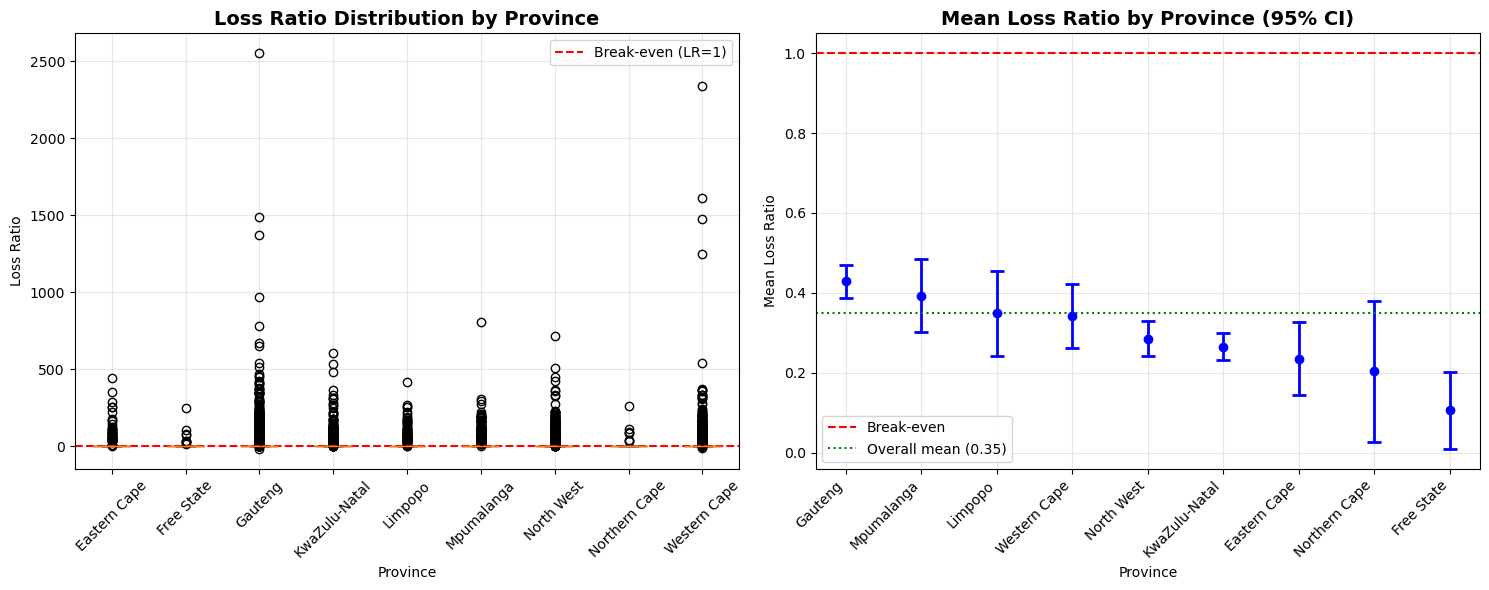

Visualization saved to: reports/hypothesis_test1_provinces.png


In [5]:
# Cell 5: Visualization for Hypothesis Test 1
print("=" * 60)
print("VISUALIZATION: Province Risk Differences")
print("=" * 60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Box plot of Loss Ratio by Province
province_order = df_valid.groupby('Province')['LossRatio'].median().sort_values(ascending=False).index

box_data = [df_valid[df_valid['Province'] == province]['LossRatio'].dropna() 
            for province in province_order]

box = ax1.boxplot(box_data, labels=province_order, patch_artist=True)
ax1.set_title('Loss Ratio Distribution by Province', fontsize=14, fontweight='bold')
ax1.set_xlabel('Province')
ax1.set_ylabel('Loss Ratio')
ax1.axhline(y=1, color='red', linestyle='--', label='Break-even (LR=1)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Color boxes based on median
colors = []
for i, province in enumerate(province_order):
    median_lr = df_valid[df_valid['Province'] == province]['LossRatio'].median()
    if median_lr > 1:
        colors.append('lightcoral')  # High risk
    elif median_lr > 0.7:
        colors.append('lightyellow')  # Medium risk
    else:
        colors.append('lightgreen')  # Low risk

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Plot 2: Mean Loss Ratio with confidence intervals
province_stats = df_valid.groupby('Province').agg({
    'LossRatio': ['mean', 'count', 'std']
}).round(4)

province_stats.columns = ['mean', 'count', 'std']
province_stats = province_stats.sort_values('mean', ascending=False)

# Calculate 95% confidence intervals
province_stats['ci_lower'] = province_stats['mean'] - 1.96 * province_stats['std'] / np.sqrt(province_stats['count'])
province_stats['ci_upper'] = province_stats['mean'] + 1.96 * province_stats['std'] / np.sqrt(province_stats['count'])

x_pos = range(len(province_stats))
ax2.errorbar(x_pos, province_stats['mean'], 
             yerr=[province_stats['mean'] - province_stats['ci_lower'], 
                   province_stats['ci_upper'] - province_stats['mean']],
             fmt='o', capsize=5, capthick=2, elinewidth=2, color='blue')

ax2.set_xticks(x_pos)
ax2.set_xticklabels(province_stats.index, rotation=45, ha='right')
ax2.set_title('Mean Loss Ratio by Province (95% CI)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Province')
ax2.set_ylabel('Mean Loss Ratio')
ax2.axhline(y=1, color='red', linestyle='--', label='Break-even')
ax2.axhline(y=df_valid['LossRatio'].mean(), color='green', linestyle=':', 
            label=f'Overall mean ({df_valid["LossRatio"].mean():.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/hypothesis_test1_provinces.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to: reports/hypothesis_test1_provinces.png")